In [1]:
import os
import pickle
from itertools import product
import logging
import copy
import random

import librosa
import numpy as np
from torch.utils.data import Dataset
import networkx as nx
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import fftconvolve
from skimage.measure import block_reduce

from ss_baselines.common.utils import to_tensor
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2025-12-17 18:28:45.914752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 18:28:46.094579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 18:28:47.06

In [2]:
class AudioGoalDataset(Dataset):
    def __init__(
        self,
        scene_graphs,
        scenes,
        split,
        use_polar_coordinates=False,
        use_cache=False,
        filter_rule='',
        # ===== 新增：磁盘 cache 参数 =====
        cache_dir="/home/Disk/yyz/sound-spaces/cache",
        cache_name=None,
        rebuild_cache=False,
    ):
        self.use_cache = use_cache
        self.files = []
        self.goals = []

        self.binaural_rir_dir = 'data/binaural_rirs/mp3d'
        self.source_sound_dir = f'data/sounds/semantic_splits/{split}'
        self.source_sound_dict = {}
        self.rir_sampling_rate = 16000
        self.num_samples_per   = 25000

        # ===== 1) 磁盘 cache 路径 =====
        os.makedirs(cache_dir, exist_ok=True)
        if cache_name is None:
            # 默认：用 split + 采样参数做名字（你也可以自定义更详细）
            cache_name = f"mp3d_{split}_pairs{self.num_samples_per}_polar{int(use_polar_coordinates)}.npz"
        cache_path = os.path.join(cache_dir, cache_name)

        # ===== 2) 如果 cache 存在且不 rebuild：直接读取 =====
        if (not rebuild_cache) and os.path.exists(cache_path):
            print(f"[AudioGoalDataset] Load cache: {cache_path}")
            data = np.load(cache_path, allow_pickle=True)

            # files: object array of tuples (rir_file, sound_file)
            self.files = data["files"].tolist()

            # goals: float32 array (N,3)
            goals_np = data["goals"].astype(np.float32)
            self.goals = [to_tensor(g) for g in goals_np]

            # 可选保存一些 meta 以做一致性检查
            # meta = data["meta"].item() if "meta" in data else {}
        else:
            # ===== 3) 否则：生成并保存 cache =====
            sound_files = os.listdir(self.source_sound_dir)
            if len(sound_files) == 0:
                raise RuntimeError(f"No sound files in {self.source_sound_dir}")
            print(f"[AudioGoalDataset] Build cache: {cache_path}")
            print("[AudioGoalDataset] sound files:", sound_files)

            for scene in tqdm(scenes, desc=f"Build ({split})"):
                scene_graph = scene_graphs[scene]
                goals = []

                subgraphs = list(nx.connected_components(scene_graph))
                sr_pairs = []
                for subgraph in subgraphs:
                    sr_pairs += list(product(subgraph, subgraph))

                random.shuffle(sr_pairs)

                kept = 0
                for s, r in sr_pairs:
                    if kept >= self.num_samples_per:
                        break
                    if s == r:
                        continue

                    sound_file = random.choice(sound_files)
                    cat = sound_file[:-4]
                    if cat not in CATEGORY_INDEX_MAPPING:
                        continue
                    index = CATEGORY_INDEX_MAPPING[cat]

                    angle = random.choice([0, 90, 180, 270])
                    rir_file = os.path.join(self.binaural_rir_dir, scene, str(angle), f"{r}_{s}.wav")

                    if not os.path.exists(rir_file):
                        continue

                    self.files.append((rir_file, sound_file))

                    delta_x = scene_graph.nodes[s]['point'][0] - scene_graph.nodes[r]['point'][0]
                    delta_y = scene_graph.nodes[s]['point'][2] - scene_graph.nodes[r]['point'][2]
                    goal_xy = self._compute_goal_xy(delta_x, delta_y, angle, use_polar_coordinates)

                    goal = to_tensor(np.zeros(3, dtype=np.float32))
                    goal[0] = float(index)
                    goal[1:] = goal_xy
                    goals.append(goal)

                    kept += 1
                    print(kept)

                self.goals += goals

            if len(self.files) == 0:
                raise RuntimeError("Built 0 samples. Check rir dir / mapping / scenes.")

            # 保存 cache（只存轻量信息）
            goals_np = torch.stack(self.goals, dim=0).cpu().numpy().astype(np.float32)
            files_np = np.array(self.files, dtype=object)

            meta = dict(
                split=split,
                use_polar_coordinates=bool(use_polar_coordinates),
                num_samples=len(self.files),
                binaural_rir_dir=self.binaural_rir_dir,
                source_sound_dir=self.source_sound_dir,
            )

            np.savez_compressed(cache_path, files=files_np, goals=goals_np, meta=np.array(meta, dtype=object))
            print(f"[AudioGoalDataset] Saved cache: {cache_path} (N={len(self.files)})")

        self.data = [None] * len(self.goals)
        self.load_source_sounds()

    def audio_length(self, sound):
        return self.source_sound_dict[sound].shape[0] // self.rir_sampling_rate

    def load_source_sounds(self):
        sound_files = os.listdir(self.source_sound_dir)
        for sound_file in sound_files:
            audio_data, sr = librosa.load(
                os.path.join(self.source_sound_dir, sound_file),
                sr=self.rir_sampling_rate
            )
            self.source_sound_dict[sound_file] = audio_data

    @staticmethod
    def _compute_goal_xy(delta_x, delta_y, angle, use_polar_coordinates):
        if angle == 0:
            x = delta_x
            y = delta_y
        elif angle == 90:
            x = delta_y
            y = -delta_x
        elif angle == 180:
            x = -delta_x
            y = -delta_y
        else:
            x = -delta_y
            y = delta_x

        if use_polar_coordinates:
            theta = np.arctan2(y, x)
            distance = np.linalg.norm([y, x])
            goal_xy = to_tensor([theta, distance])
        else:
            goal_xy = to_tensor([x, y])
        return goal_xy

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        if (self.use_cache and self.data[item] is None) or (not self.use_cache):
            rir_file, sound_file = self.files[item]
            audiogoal = self.compute_audiogoal(rir_file, sound_file)
            spectrogram = to_tensor(self.compute_spectrogram(audiogoal))
            inputs_outputs = ([spectrogram], self.goals[item])

            if self.use_cache:
                self.data[item] = inputs_outputs
        else:
            inputs_outputs = self.data[item]
        return inputs_outputs

    def compute_audiogoal(self, binaural_rir_file, sound_file):
        sampling_rate = self.rir_sampling_rate
        try:
            sampling_freq, binaural_rir = wavfile.read(binaural_rir_file)
        except ValueError:
            logging.warning(f"{binaural_rir_file} file is not readable")
            binaural_rir = np.zeros((sampling_rate, 2), dtype=np.float32)

        if len(binaural_rir) == 0:
            logging.debug(f"Empty RIR file at {binaural_rir_file}")
            binaural_rir = np.zeros((sampling_rate, 2), dtype=np.float32)

        current_source_sound = self.source_sound_dict[sound_file]
        index = random.randint(0, self.audio_length(sound_file) - 2)

        if index * sampling_rate - binaural_rir.shape[0] < 0:
            source_sound = current_source_sound[: (index + 1) * sampling_rate]
            binaural_convolved = np.array([
                fftconvolve(source_sound, binaural_rir[:, channel])
                for channel in range(binaural_rir.shape[-1])
            ])
            audiogoal = binaural_convolved[:, index * sampling_rate: (index + 1) * sampling_rate]
        else:
            source_sound = current_source_sound[
                index * sampling_rate - binaural_rir.shape[0] : (index + 1) * sampling_rate
            ]
            binaural_convolved = np.array([
                fftconvolve(source_sound, binaural_rir[:, channel], mode='valid')
                for channel in range(binaural_rir.shape[-1])
            ])
            audiogoal = binaural_convolved[:, :-1]

        return audiogoal

    @staticmethod
    def compute_spectrogram(audiogoal):
        def compute_stft(signal):
            n_fft = 512
            hop_length = 160
            win_length = 400
            stft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
            stft = block_reduce(stft, block_size=(4, 4), func=np.mean)
            return stft

        channel1_magnitude = np.log1p(compute_stft(audiogoal[0]))
        channel2_magnitude = np.log1p(compute_stft(audiogoal[1]))
        spectrogram = np.stack([channel1_magnitude, channel2_magnitude], axis=-1)
        return spectrogram

In [4]:
import os
import torch
import numpy as np

from soundspaces.utils import load_metadata
from ss_baselines.savi.pretraining_ours.audiogoal_predictor import AudioGoalPredictor
# from ss_baselines.savi.pretraining_ours.audiogoal_dataset import AudioGoalDataset
from ss_baselines.savi.config.default import get_config
from soundspaces.mp3d_utils import SCENE_SPLITS

# -----------------------
# 1) 基本配置（你按需改）
# -----------------------
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = "/home/Disk/sound-space/ss_baselines/savi/config/semantic_audionav/savi.yaml"
SPLIT = "train"                 # "train" / "val" / "test"
USE_CACHE = True             # 建议 inference 时 False，避免占用巨大内存
           # 你要看的 dataset index
PREDICT_LABEL = False
PREDICT_LOCATION = True

# 可选：加载 ckpt（设为 None 就不加载）
CKPT_PATH = "/home/Disk/yyz/sound-spaces/weights/savi/best_val.pth"   # or None


# -----------------------
# 2) 构建 config / dataset
# -----------------------
config = get_config(config_paths=CONFIG_PATH, opts=None, run_type=None)
meta_dir = config.TASK_CONFIG.SIMULATOR.AUDIO.METADATA_DIR

scenes = SCENE_SPLITS[SPLIT]

scene_graphs = {}
for scene in scenes:
    points, graph = load_metadata(os.path.join(meta_dir, "mp3d", scene))
    scene_graphs[scene] = graph

dataset = AudioGoalDataset(
    scene_graphs=scene_graphs,
    scenes=scenes,
    split=SPLIT,
    use_polar_coordinates=False,
    use_cache=USE_CACHE,
)

print(f"[INFO] dataset split={SPLIT}, len={len(dataset)}")


# -----------------------
# 3) 构建模型 + 可选加载权重
# -----------------------
# model = AudioGoalPredictor(
#     predict_label=PREDICT_LABEL,
#     predict_location=PREDICT_LOCATION
# ).to(DEVICE)
# model.eval()

# if CKPT_PATH is not None and os.path.exists(CKPT_PATH):
#     ckpt = torch.load(CKPT_PATH, map_location="cpu")
#     # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
#     if "audiogoal_predictor" in ckpt:
#         model.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
#         print(f"[INFO] loaded ckpt: {CKPT_PATH}")
#     else:
#         # 万一你保存的是裸 state_dict
#         model.load_state_dict(ckpt, strict=True)
#         print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
# else:
#     print("[WARN] ckpt not loaded (path is None or not exists).")




[AudioGoalDataset] Load cache: /home/Disk/yyz/sound-spaces/cache/mp3d_train_pairs25000_polar0.npz
[INFO] dataset split=train, len=671936


N goals: 671936
dist min/max/mean/std: 1.000 / 71.400 / 9.920 / 7.754

Bin stats:
[ 1.0,  2.0) m :  37667  ( 7.04%)
[ 2.0,  3.0) m :  52417  ( 9.79%)
[ 3.0,  4.0) m :  50788  ( 9.49%)
[ 4.0,  5.0) m :  48092  ( 8.98%)
[ 5.0,  6.0) m :  58678  (10.96%)
[ 6.0,  7.0) m :  41974  ( 7.84%)
[ 7.0,  8.0) m :  44020  ( 8.22%)
[ 8.0,  9.0) m :  40706  ( 7.60%)
[ 9.0, 10.0) m :  33567  ( 6.27%)
[10.0, 11.0) m :  32097  ( 6.00%)
[11.0, 12.0) m :  25132  ( 4.69%)
[12.0, 13.0) m :  25575  ( 4.78%)
[13.0, 14.0) m :  23822  ( 4.45%)
[14.0, 15.0) m :  20838  ( 3.89%)

Max/Min bin count ratio: 2.8159132354352625

Label distribution (top 20):
label   1: 32304
label   0: 32280
label   8: 32246
label  10: 32236
label  20: 32159
label  11: 32120
label  12: 32086
label  14: 32030
label  17: 31988
label   3: 31986
label   4: 31976
label   9: 31965
label   6: 31946
label   5: 31932
label  18: 31931
label  15: 31925
label   2: 31868
label  13: 31838
label  16: 31804
label   7: 31770


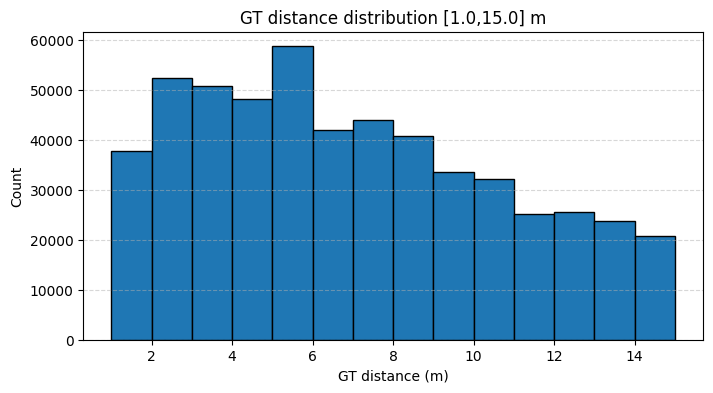

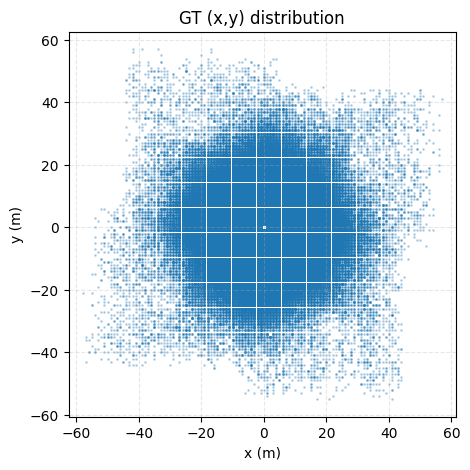

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def goals_to_numpy(goals):
    # goals: list[Tensor(3,)] or list[np.array]
    if len(goals) == 0:
        return np.zeros((0, 3), dtype=np.float32)
    if torch.is_tensor(goals[0]):
        g = torch.stack(goals, dim=0).cpu().numpy()  # (N,3)
    else:
        g = np.asarray(goals, dtype=np.float32)
    return g

def stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True):
    g = goals_to_numpy(dataset.goals)   # (N,3) -> [label, x, y]
    labels = g[:, 0].astype(np.int64)
    xs = g[:, 1]
    ys = g[:, 2]
    dists = np.sqrt(xs*xs + ys*ys)

    print(f"N goals: {len(dists)}")
    if len(dists) > 0:
        print(f"dist min/max/mean/std: {dists.min():.3f} / {dists.max():.3f} / {dists.mean():.3f} / {dists.std():.3f}")

    # 分桶统计
    edges = np.linspace(dist_min, dist_max, num_bins + 1)
    counts, _ = np.histogram(dists, bins=edges)

    total = counts.sum()
    print("\nBin stats:")
    for i in range(num_bins):
        lo, hi = edges[i], edges[i+1]
        ratio = counts[i] / total if total > 0 else 0
        print(f"[{lo:4.1f}, {hi:4.1f}) m : {counts[i]:6d}  ({ratio*100:5.2f}%)")
    if total > 0:
        print("\nMax/Min bin count ratio:", counts.max() / max(counts.min(), 1))

    # label 分布（可选）
    uniq, cnt = np.unique(labels, return_counts=True)
    print("\nLabel distribution (top 20):")
    order = np.argsort(-cnt)
    for u, c in list(zip(uniq[order], cnt[order]))[:20]:
        print(f"label {u:3d}: {c}")

    if plot and len(dists) > 0:
        plt.figure(figsize=(8,4))
        plt.hist(dists, bins=edges, edgecolor="black")
        plt.xlabel("GT distance (m)")
        plt.ylabel("Count")
        plt.title(f"GT distance distribution [{dist_min},{dist_max}] m")
        plt.grid(True, axis="y", linestyle="--", alpha=0.5)
        plt.show()

        # (x,y) scatter 看方向覆盖
        plt.figure(figsize=(5,5))
        plt.scatter(xs, ys, s=1, alpha=0.25)
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.axis("equal")
        plt.title("GT (x,y) distribution")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.show()

    return dists, counts, edges

# 用法
dists, counts, edges = stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True)


In [6]:
for SAMPLE_INDEX in range(1,2):
    # SAMPLE_INDEX = 1  
    (inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
    spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)

In [47]:
# -----------------------
# 4) 取一个 sample，跑一次 forward
# -----------------------
for SAMPLE_INDEX in range(1,2):
    # SAMPLE_INDEX = 1  
    (inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
    spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
    
    # 加 batch 维度 -> (1, 2, 65, 26)
    x = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
    
    with torch.no_grad():
        pred = model({"spectrogram": x})          # shape: (1, C) or (1, C+2) or (1,2)
        pred = pred.squeeze(0).cpu()
    
    gt_np = gt.cpu().numpy() if torch.is_tensor(gt) else np.array(gt)
    
    # print("========== SAMPLE ==========")
    # print("Index:", SAMPLE_INDEX)
    # print("Spectrogram shape:", spectrogram.shape)
    
    # print("\n========== GT ==========")
    # # gt[0] 是 label index；gt[1:] 是 (x,y)
    # print("GT label:", int(gt_np[0]))
    # print("GT xy   :", gt_np[1:])
    
    print("\n========== PRED ==========")
    if PREDICT_LABEL and PREDICT_LOCATION:
        # pred[:-2] logits, pred[-2:] xy
        logits = pred[:-2].numpy()
        xy = pred[-2:].numpy()
        pred_label = int(np.argmax(np.abs(logits)))
        print("Pred label:", pred_label)
        print("Pred xy   :", xy)
    elif PREDICT_LABEL:
        logits = pred.numpy()
        pred_label = int(np.argmax(np.abs(logits)))
        print("Pred label:", pred_label)
    elif PREDICT_LOCATION:
        xy = pred.numpy()
        xy = np.round(xy)
        # pred_y = np.round(xy)
        print("Pred xy:",xy, "GT",gt_np[1:])
    
    # print("\n[INFO] raw pred tensor shape:", tuple(pred.shape))



========== PRED ==========
Pred xy: [ 1. -0.] GT [1. 0.]
